In [ ]:
### If Using Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#cd /content/drive/My Drive/SWOT/data

Mounted at /content/drive


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 29.2 MB/s eta 0:00:00


### Figure 2:

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
from pathlib import Path
import os
import numpy as np
import xarray as xr
import geopandas as gpd
from tqdm import tqdm, tqdm_notebook
from shapely.geometry import shape
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft

aoi_json = {
        "coordinates":
            [
          [
            [
              -27.510405558791888,
              72.88742048041215
            ],
            [
              -27.510405558791888,
              72.77010247646908
            ],
            [
              -26.41621125698765,
              72.77010247646908
            ],
            [
              -26.41621125698765,
              72.88742048041215
            ],
            [
              -27.510405558791888,
              72.88742048041215
            ]
          ]
        ],
        "type": "Polygon"
      }

# Create shapely polygon from JSON
aoi = shape(aoi_json)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


import pickle
with open('bathy_dict.pkl', 'rb') as f:
    bathy_dict = pickle.load(f)

all_longitudes = bathy_dict['longitude']
all_latitudes = bathy_dict['latitude']
all_depths = bathy_dict['bathymetry']
# Assuming all_longitudes, all_latitudes, and all_elevations are your 1D arrays
# Reshape your arrays to create a grid; you may need to adjust the shapes according to your data.
# Here is a placeholder shape; adjust it based on the unique values in your arrays.

# Get unique values and sort them
unique_longitudes = np.unique(all_longitudes)
unique_latitudes = np.unique(all_latitudes)

# Create a mesh grid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(unique_longitudes, unique_latitudes)

# Create an elevation grid that matches the lon_grid and lat_grid
# Make sure to reshape or interpolate the elevations accordingly
elevation_grid = np.zeros(lon_grid.shape)  # Initialize the grid

# Fill the elevation grid based on the unique lat/lon pairs
for i in range(len(all_longitudes)):
    lon_idx = np.where(unique_longitudes == all_longitudes[i])[0][0]
    lat_idx = np.where(unique_latitudes == all_latitudes[i])[0][0]
    elevation_grid[lat_idx, lon_idx] = all_depths[i]

#### Helper Functions:

In [ ]:
from datetime import datetime, timedelta

def format_datetime(date_str, reference_date_str):
    # Parse the date string
    dt = datetime.strptime(date_str, '%Y%m%dT%H%M%S')

    # Format the date and time
    formatted_date = dt.strftime('%b %d, %H:%M')

    # Parse the reference date
    reference_date = datetime.strptime(reference_date_str, '%Y%m%dT%H%M%S')

    # Calculate the difference in fractional days
    days_since_event = (dt - reference_date).total_seconds() / 86400

    # Create the final string
    return f"{formatted_date}, +{days_since_event:.1f}d post-tsunami"

def calculate_parallel_lines(point1, point2, offset_distance):
    """
    Calculate points for lines parallel to the line formed by point1 and point2,
    offset by a given distance.

    Parameters:
    - point1: tuple or list of the first point (x1, y1)
    - point2: tuple or list of the second point (x2, y2)
    - offset_distance: the distance by which to offset the parallel lines

    Returns:
    - point1_offset_up, point2_offset_up: points for the line offset in one direction
    - point1_offset_down, point2_offset_down: points for the line offset in the opposite direction
    """
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)

    # Calculate the direction vector of the original line
    direction = point2 - point1

    # Normalize the direction vector
    direction_norm = direction / np.linalg.norm(direction)

    # Calculate the perpendicular vector (90-degree rotation)
    perp_vector = np.array([-direction_norm[1], direction_norm[0]])

    # Calculate new parallel lines by offsetting along the perpendicular vector
    # Positive offset
    point1_offset_up = point1 + offset_distance * perp_vector
    point2_offset_up = point2 + offset_distance * perp_vector

    # Negative offset (other direction)
    point1_offset_down = point1 - offset_distance * perp_vector
    point2_offset_down = point2 - offset_distance * perp_vector

    return (point1_offset_up, point2_offset_up), (point1_offset_down, point2_offset_down)

def letter_subplots(axes=None, letters=None, xoffset=-0.1, yoffset=1.0, **kwargs):
    """Add letters to the corners of subplots (panels). By default each axis is
    given an uppercase bold letter label placed in the upper-left corner.
    Args
        axes : list of pyplot ax objects. default plt.gcf().axes.
        letters : list of strings to use as labels, default ["A", "B", "C", ...]
        xoffset, yoffset : positions of each label relative to plot frame
          (default -0.1,1.0 = upper left margin). Can also be a list of
          offsets, in which case it should be the same length as the number of
          axes.
        Other keyword arguments will be passed to annotate() when panel letters
        are added.
    Returns:
        list of strings for each label added to the axes
    Examples:
        Defaults:
            >>> fig, axes = plt.subplots(1,3)
            >>> letter_subplots() # boldfaced A, B, C

        Common labeling schemes inferred from the first letter:
            >>> fig, axes = plt.subplots(1,4)
            >>> letter_subplots(letters='(a)') # panels labeled (a), (b), (c), (d)
        Fully custom lettering:
            >>> fig, axes = plt.subplots(2,1)
            >>> letter_subplots(axes, letters=['(a.1)', '(b.2)'], fontweight='normal')
        Per-axis offsets:
            >>> fig, axes = plt.subplots(1,2)
            >>> letter_subplots(axes, xoffset=[-0.1, -0.15])

        Matrix of axes:
            >>> fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
            >>> letter_subplots(fig.axes) # fig.axes is a list when axes is a 2x2 matrix

    HELPER FUNCTION CREATED BY:
    # Jim Bagrow
    """

    # get axes:
    if axes is None:
        axes = plt.gcf().axes
    # handle single axes:
    try:
        iter(axes)
    except TypeError:
        axes = [axes]

    # set up letter defaults (and corresponding fontweight):
    fontweight = "bold"
    ulets = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[:len(axes)])
    llets = list('abcdefghijklmnopqrstuvwxyz'[:len(axes)])
    if letters is None or letters == "A":
        letters = ulets
    elif letters == "(a)":
        letters = [ "({})".format(lett) for lett in llets ]
        fontweight = "normal"
    elif letters == "(A)":
        letters = [ "({})".format(lett) for lett in ulets ]
        fontweight = "normal"
    elif letters in ("lower", "lowercase", "a"):
        letters = llets

    # make sure there are x and y offsets for each ax in axes:
    if isinstance(xoffset, (int, float)):
        xoffset = [xoffset]*len(axes)
    else:
        assert len(xoffset) == len(axes)
    if isinstance(yoffset, (int, float)):
        yoffset = [yoffset]*len(axes)
    else:
        assert len(yoffset) == len(axes)

    # defaults for annotate (kwargs is second so it can overwrite these defaults):
    my_defaults = dict(fontweight=fontweight, fontsize='large', ha="center",
                       va='center', xycoords='axes fraction', annotation_clip=False)
    kwargs = dict( list(my_defaults.items()) + list(kwargs.items()))

    list_txts = []
    for ax,lbl,xoff,yoff in zip(axes,letters,xoffset,yoffset):
        t = ax.annotate(lbl, xy=(xoff,yoff), **kwargs)
        list_txts.append(t)
    return list_txts


#### Figure 2:

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

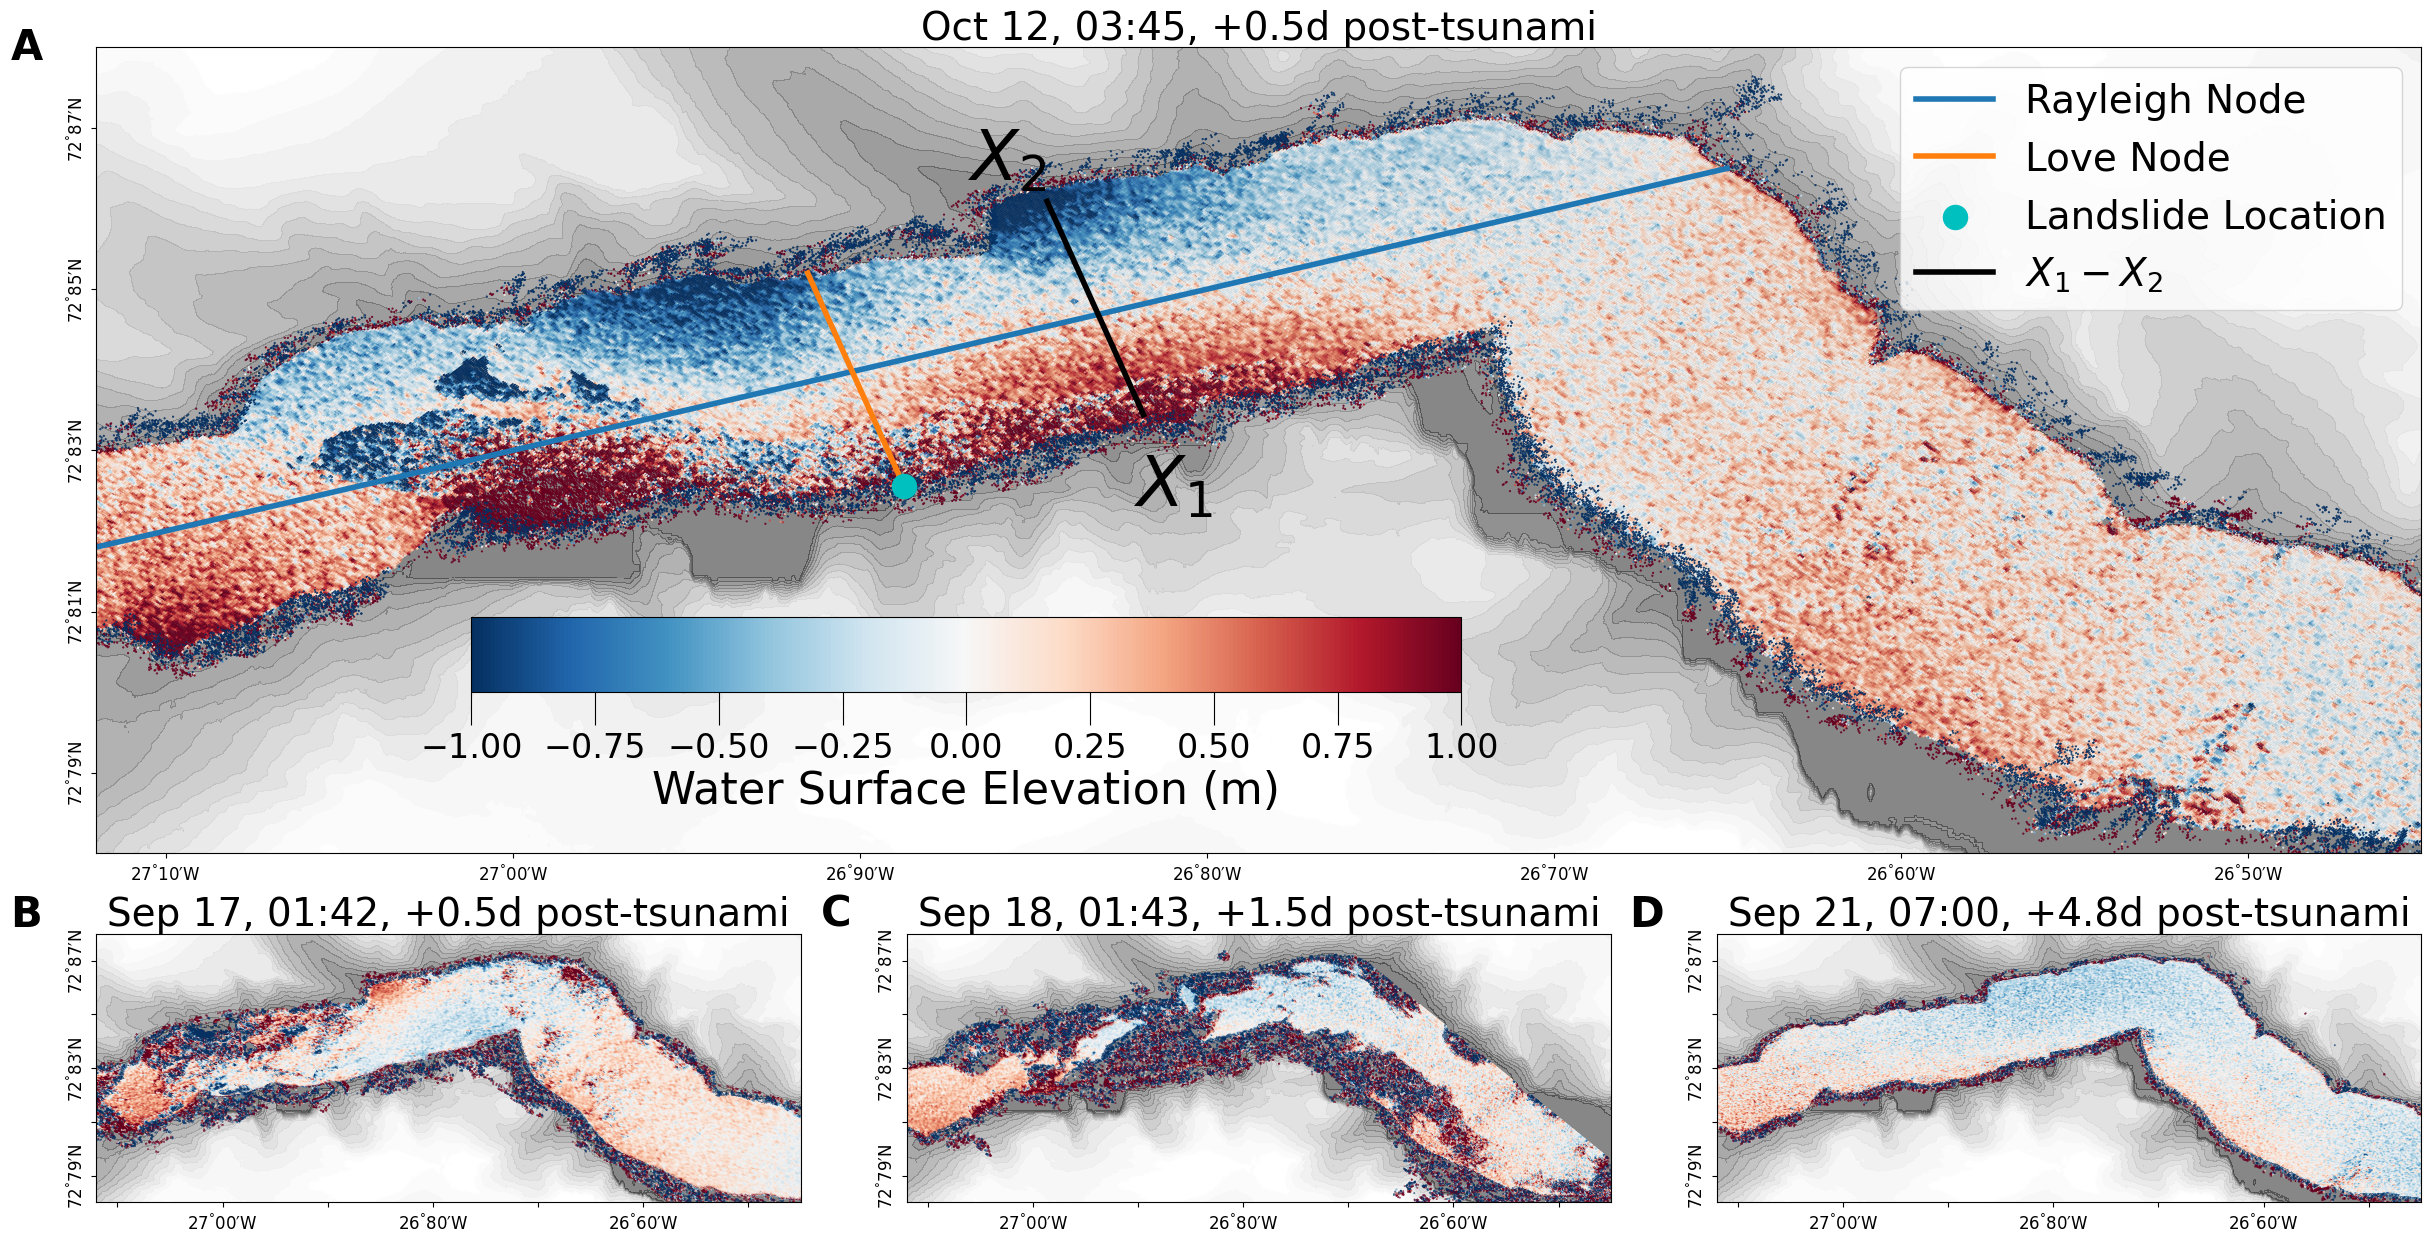

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl


# Create the figure
fig = plt.figure(figsize=(30, 15))  # Adjust figure size as needed

# Create a GridSpec with 2 rows and 3 columns
# The top figure (48x24) takes the full top row (spanning all columns),
# while the bottom figures have equal sizes in the second row.
gs = gridspec.GridSpec(2, 3, height_ratios=[24, 8], width_ratios=[8, 8, 8], hspace=0.15, wspace=0.15)

# Top plot (48x24) - spans all 3 columns
ax1 = fig.add_subplot(gs[0, :])
tsunamis = [
 'SWOT_L2_HR_PIXC_004_570_021R_20231012T034544_20231012T034555_PGC0_01.nc']

combos = [
          ['SWOT_L2_HR_PIXC_004_570_020R_20231012T034533_20231012T034545_PGC0_01.nc']]

titlesize = 28


for indy, filetotest in enumerate(tsunamis[:]):
  # create a path to it and assert it exists
  file = Path('./Fjord_Oct11/' + filetotest)
  assert file.exists()

  # Load the file to the XArray.Dataset
  ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

  # Load a GeoPandas DataFrame with the points and some variables
  gdf = gpd.GeoDataFrame(
      data={
          'height': ds_pixc.height.values.astype('float32'),
          'latitude': ds_pixc.latitude.values.astype('float32'),
          'longitude': ds_pixc.longitude.values.astype('float32'),
          'geoid': ds_pixc.geoid.values.astype('float32')
      },
      geometry=gpd.points_from_xy(
          ds_pixc.longitude.values,
          ds_pixc.latitude.values
      )
  )

  gdf_filtered = gdf[gdf.geometry.within(aoi)]

  gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
  gdf_filtered2 = gdf_filtered[gdf_filtered['height'] < 5]

  contour = ax1.contourf(lon_grid, lat_grid, elevation_grid, cmap='Greys_r', levels=20, vmin = -200, vmax = 2000, zorder = 0, alpha = 0.5)

  lat1 = gdf_filtered2['latitude']
  lon1 = gdf_filtered2['longitude']
  height1 = gdf_filtered2['height']
  scatter1 = ax1.scatter(lon1, lat1, c = height1, cmap = 'RdBu_r', vmin = -2, vmax = 0, s = 0.3, zorder = 1)

  if combos[indy] != None:
    file = Path('./Fjord_Oct11/' + combos[indy][0])
    assert file.exists()
    # Load the file to the XArray.Dataset
    ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

    # Load a GeoPandas DataFrame with the points and some variables
    gdf = gpd.GeoDataFrame(
        data={
            'height': ds_pixc.height.values.astype('float32'),
            'latitude': ds_pixc.latitude.values.astype('float32'),
            'longitude': ds_pixc.longitude.values.astype('float32'),
            'geoid': ds_pixc.geoid.values.astype('float32')
        },
        geometry=gpd.points_from_xy(
            ds_pixc.longitude.values,
            ds_pixc.latitude.values
        )
    )

    # Create a custom colormap to display the classes
    gdf_filtered = gdf[gdf.geometry.within(aoi)]
    gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
    gdf_filtered2_other = gdf_filtered[(gdf_filtered['height'] < 5)]
    lat2 = gdf_filtered2_other['latitude']
    lon2 = gdf_filtered2_other['longitude']
    height2 = gdf_filtered2_other['height']
    ax1.scatter(lon2, lat2, c = height2, cmap = 'RdBu_r', vmin = -2.0, vmax = 0.0, s = 0.3, zorder = 1)

  reference_event_date = '20231011T160000'  # Example reference date
  event_date = filetotest[29:44]
  formatted_output = format_datetime(event_date, reference_event_date)
  plt.title(formatted_output, fontsize = titlesize)

  ax1.plot((-27.2, -26.65), (72.81, 72.865), label='Rayleigh Node', linewidth = 4)
  ax1.plot((-26.887218170796558, -26.915), (72.82552984710814, 72.852), label='Love Node', linewidth = 4)
  ax1.scatter(-26.887218170796558, 72.82552984710814, color='c', s=300, label = 'Landslide Location', zorder = 10)

  # Add colorbar for the scatter plot, placing it inside the plot
  cbar_ax = fig.add_axes([0.25, 0.45, 0.33, 0.05])  # Adjust position [left, bottom, width, height]

  norm = mpl.colors.Normalize(vmin=-1, vmax=1)

  colorbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap='RdBu_r',
                                  norm=norm,
                                  orientation='horizontal')
  #colorbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='horizontal')

  colorbar.ax.tick_params(labelsize=24, size = 24)
  cbar_ax.set_xlabel('Water Surface Elevation (m)', fontsize = 32)

  ax1.set_xlim(-27.12, -26.45)
  ax1.set_ylim(72.78,72.88)
  love_p1, love_p2 = (-26.887218170796558,72.82552984710814), (-26.915,72.852)
  (up_line, down_line) = calculate_parallel_lines(love_p1, love_p2, 0.1)

  p1, p2 = down_line
  ax1.plot((p1[0],p2[0]), (p1[1]-.0635,p2[1]-.0635), color = 'k', linewidth = 4, label = '$X_1 - X_2$')
  # Annotate the first point as X_1
  ax1.text(p1[0]+.02, p1[1] - 0.0765, '$X_1$', fontsize=50, ha='right', va='bottom', color='k')

  # Annotate the second point as X_2
  ax1.text(p2[0], p2[1] - 0.0625, '$X_2$', fontsize=50, ha='right', va='bottom', color='k')

  #ax1.grid(linewidth = 2)

  ax1.legend(fontsize = 28, loc = 'upper right')


# Bottom-left plot (24x8)
ax2 = fig.add_subplot(gs[1, 0])

tsunamis = ['SWOT_L2_HR_PIXC_003_451_287L_20230917T014254_20230917T014305_PGC0_01.nc']

combined_17 = ['SWOT_L2_HR_PIXC_003_451_288L_20230917T014304_20230917T014315_PGC0_01.nc']

combos = [combined_17]

for indy, filetotest in enumerate(tsunamis[:]):
  # create a path to it and assert it exists
  file = Path('./Fjord/' + filetotest)
  assert file.exists()

  # Load the file to the XArray.Dataset
  ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

  # Load a GeoPandas DataFrame with the points and some variables
  gdf = gpd.GeoDataFrame(
      data={
          'height': ds_pixc.height.values.astype('float32'),
          'latitude': ds_pixc.latitude.values.astype('float32'),
          'longitude': ds_pixc.longitude.values.astype('float32'),
          'geoid': ds_pixc.geoid.values.astype('float32')
      },
      geometry=gpd.points_from_xy(
          ds_pixc.longitude.values,
          ds_pixc.latitude.values
      )
  )

  gdf_filtered = gdf[gdf.geometry.within(aoi)]

  gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
  gdf_filtered2 = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]

  contour = ax2.contourf(lon_grid, lat_grid, elevation_grid, cmap='Greys_r', levels=20, vmin = -200, vmax = 2000, zorder = 0, alpha = 0.5)

  lat1 = gdf_filtered2['latitude']
  lon1 = gdf_filtered2['longitude']
  height1 = gdf_filtered2['height']
  scatter1 = ax2.scatter(lon1, lat1, c = height1, cmap = 'RdBu_r', vmin = -1, vmax = 1, s = 0.1, zorder = 1)

  if combos[indy] != None:
    file = Path('./Fjord/' + combos[indy][0])
    assert file.exists()
    # Load the file to the XArray.Dataset
    ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

    # Load a GeoPandas DataFrame with the points and some variables
    gdf = gpd.GeoDataFrame(
        data={
            'height': ds_pixc.height.values.astype('float32'),
            'latitude': ds_pixc.latitude.values.astype('float32'),
            'longitude': ds_pixc.longitude.values.astype('float32'),
            'geoid': ds_pixc.geoid.values.astype('float32')
        },
        geometry=gpd.points_from_xy(
            ds_pixc.longitude.values,
            ds_pixc.latitude.values
        )
    )

    # Create a custom colormap to display the classes
    gdf_filtered = gdf[gdf.geometry.within(aoi)]
    gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
    gdf_filtered2_other = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]
    lat2 = gdf_filtered2_other['latitude']
    lon2 = gdf_filtered2_other['longitude']
    height2 = gdf_filtered2_other['height']
    ax2.scatter(lon2, lat2, c = height2, cmap = 'RdBu_r', vmin = -1.0, vmax = 1.0, s = 0.1, zorder = 1)

  reference_event_date = '20230916T123500'  # Example reference date
  event_date = filetotest[29:44]
  formatted_output = format_datetime(event_date, reference_event_date)
  ax2.set_title(formatted_output, fontsize = titlesize)


  ax2.set_xlim(-27.12, -26.45)
  ax2.set_ylim(72.78,72.88)
  #ax2.grid(linewidth = 2)


# Bottom-middle plot (24x8)
ax3 = fig.add_subplot(gs[1, 1])
tsunamis = ['SWOT_L2_HR_PIXC_003_479_288R_20230918T014335_20230918T014346_PGC0_01.nc']

combos = [None]

for indy, filetotest in enumerate(tsunamis[:]):
  # create a path to it and assert it exists
  file = Path('./Fjord/' + filetotest)
  assert file.exists()

  # Load the file to the XArray.Dataset
  ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

  # Load a GeoPandas DataFrame with the points and some variables
  gdf = gpd.GeoDataFrame(
      data={
          'height': ds_pixc.height.values.astype('float32'),
          'latitude': ds_pixc.latitude.values.astype('float32'),
          'longitude': ds_pixc.longitude.values.astype('float32'),
          'geoid': ds_pixc.geoid.values.astype('float32')
      },
      geometry=gpd.points_from_xy(
          ds_pixc.longitude.values,
          ds_pixc.latitude.values
      )
  )

  gdf_filtered = gdf[gdf.geometry.within(aoi)]

  gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
  gdf_filtered2 = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]

  contour = ax3.contourf(lon_grid, lat_grid, elevation_grid, cmap='Greys_r', levels=20, vmin = -200, vmax = 2000, zorder = 0, alpha = 0.5)

  lat1 = gdf_filtered2['latitude']
  lon1 = gdf_filtered2['longitude']
  height1 = gdf_filtered2['height']
  scatter1 = ax3.scatter(lon1, lat1, c = height1, cmap = 'RdBu_r', vmin = -1, vmax = 1, s = 0.1, zorder = 1)

  if combos[indy] != None:
    file = Path('./Fjord/' + combos[indy][0])
    assert file.exists()
    # Load the file to the XArray.Dataset
    ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

    # Load a GeoPandas DataFrame with the points and some variables
    gdf = gpd.GeoDataFrame(
        data={
            'height': ds_pixc.height.values.astype('float32'),
            'latitude': ds_pixc.latitude.values.astype('float32'),
            'longitude': ds_pixc.longitude.values.astype('float32'),
            'geoid': ds_pixc.geoid.values.astype('float32')
        },
        geometry=gpd.points_from_xy(
            ds_pixc.longitude.values,
            ds_pixc.latitude.values
        )
    )

    # Create a custom colormap to display the classes
    gdf_filtered = gdf[gdf.geometry.within(aoi)]
    gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
    gdf_filtered2_other = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]
    lat2 = gdf_filtered2_other['latitude']
    lon2 = gdf_filtered2_other['longitude']
    height2 = gdf_filtered2_other['height']
    ax3.scatter(lon2, lat2, c = height2, cmap = 'RdBu_r', vmin = -1.0, vmax = 1.0, s = 0.1, zorder = 1)

  reference_event_date = '20230916T123500'  # Example reference date
  event_date = filetotest[29:44]
  formatted_output = format_datetime(event_date, reference_event_date)
  ax3.set_title(formatted_output, fontsize = titlesize)

  ax3.set_xlim(-27.12, -26.45)
  ax3.set_ylim(72.78,72.88)
  #ax3.grid(linewidth = 2)


# Bottom-right plot (24x8)
ax4 = fig.add_subplot(gs[1, 2])
tsunamis = ['SWOT_L2_HR_PIXC_003_570_020R_20230921T070031_20230921T070042_PGC0_01.nc']

combined_21 = ['SWOT_L2_HR_PIXC_003_570_021R_20230921T070041_20230921T070052_PGC0_01.nc']

combos = [combined_21]

for indy, filetotest in enumerate(tsunamis[:]):
  # create a path to it and assert it exists
  file = Path('./Fjord/' + filetotest)
  assert file.exists()

  # Load the file to the XArray.Dataset
  ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

  # Load a GeoPandas DataFrame with the points and some variables
  gdf = gpd.GeoDataFrame(
      data={
          'height': ds_pixc.height.values.astype('float32'),
          'latitude': ds_pixc.latitude.values.astype('float32'),
          'longitude': ds_pixc.longitude.values.astype('float32'),
          'geoid': ds_pixc.geoid.values.astype('float32')
      },
      geometry=gpd.points_from_xy(
          ds_pixc.longitude.values,
          ds_pixc.latitude.values
      )
  )

  gdf_filtered = gdf[gdf.geometry.within(aoi)]

  gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
  gdf_filtered2 = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]

  contour = ax4.contourf(lon_grid, lat_grid, elevation_grid, cmap='Greys_r', levels=20, vmin = -200, vmax = 2000, zorder = 0, alpha = 0.5)

  lat1 = gdf_filtered2['latitude']
  lon1 = gdf_filtered2['longitude']
  height1 = gdf_filtered2['height']
  scatter1 = ax4.scatter(lon1, lat1, c = height1, cmap = 'RdBu_r', vmin = -1.5, vmax = 0.5, s = 0.1, zorder = 1)

  if combos[indy] != None:
    file = Path('./Fjord/' + combos[indy][0])
    assert file.exists()
    # Load the file to the XArray.Dataset
    ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='h5netcdf')

    # Load a GeoPandas DataFrame with the points and some variables
    gdf = gpd.GeoDataFrame(
        data={
            'height': ds_pixc.height.values.astype('float32'),
            'latitude': ds_pixc.latitude.values.astype('float32'),
            'longitude': ds_pixc.longitude.values.astype('float32'),
            'geoid': ds_pixc.geoid.values.astype('float32')
        },
        geometry=gpd.points_from_xy(
            ds_pixc.longitude.values,
            ds_pixc.latitude.values
        )
    )

    # Create a custom colormap to display the classes
    gdf_filtered = gdf[gdf.geometry.within(aoi)]
    gdf_filtered['height'] = gdf_filtered['height'] - gdf_filtered['geoid']
    gdf_filtered2_other = gdf_filtered[(gdf_filtered['height'] < 4) & (gdf_filtered['height'] > -4)]
    lat2 = gdf_filtered2_other['latitude']
    lon2 = gdf_filtered2_other['longitude']
    height2 = gdf_filtered2_other['height']
    ax4.scatter(lon2, lat2, c = height2, cmap = 'RdBu_r', vmin = -1.5, vmax = 0.5, s = 0.1, zorder = 1)

  reference_event_date = '20230916T123500'  # Example reference date
  event_date = filetotest[29:44]
  formatted_output = format_datetime(event_date, reference_event_date)
  ax4.set_title(formatted_output, fontsize = titlesize)

  ax4.set_xlim(-27.12, -26.45)
  ax4.set_ylim(72.78,72.88)
  #ax4.grid(linewidth = 2)



ax1.set_xticks([-27.1,-27.0,-26.9,-26.8,-26.7,-26.6,-26.5],
 [r'$27^\degree10′$W',r'$27^\degree00′$W',r'$26^\degree90′$W',r'$26^\degree80′$W',r'$26^\degree70′$W',r'$26^\degree60′$W',r'$26^\degree50′$W'])

ax1.set_yticks([72.79,72.81, 72.83, 72.85,72.87],
 [r'$72^\degree79′$N',r'$72^\degree81′$N',r'$72^\degree83′$N',r'$72^\degree85′$N',r'$72^\degree87′$N'],
              rotation = 90,
              va = 'center')

ax1.tick_params(axis='both', which='major', labelsize=12)

for ax in (ax2, ax3, ax4):
  ax.set_xticks([-27.1,-27.0,-26.9,-26.8,-26.7,-26.6,-26.5],
  [r'',r'$27^\degree00′$W',r'',r'$26^\degree80′$W',r'',r'$26^\degree60′$W',r''])

  ax.set_yticks([72.79,72.81, 72.83, 72.85,72.87],
  [r'$72^\degree79′$N',r'',r'$72^\degree83′$N',r'',r'$72^\degree87′$N'],
              rotation = 90,
              va='center')
  ax.tick_params(axis='both', which='major', labelsize=12)

letter_subplots(letters=['A', '', 'B', 'C', 'D'], fontsize = 30, xoffset = [-0.03,-.1,-.1,-.1,-.1], yoffset = [1,1.075,1.075,1.075,1.075]) # parenthetical letters, like many math and eng venues use

# Display the plot
plt.savefig("Figure_2.pdf", dpi = 300, bbox_inches='tight')
plt.savefig("Figure_2.png", dpi = 300, bbox_inches='tight')
plt.show()